In [1]:
## Créer une représentation de la ville de Brest en cellules de Voronoi

In [1]:
# Importer les packqges nécéssaires

import datetime
import locale
import textwrap

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import overpy
import geopy.distance
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib as mpl
import smopy
import random
import matplotlib.patches as patches
%matplotlib inline

# Setting french locale
locale.setlocale(locale.LC_ALL, 'fr_FR.UTF-8')

PLOT_VIGILO_RELEASE_DATE = True
PLOT_VIGILO_PRESS_CONFERENCE_DATE = True

sns.set_style("darkgrid")
sns.set_context("talk", font_scale=0.8)
blue, orange = sns.color_palette("muted", 2)

Lowered zoom level to keep map size reasonable. (z = 13)


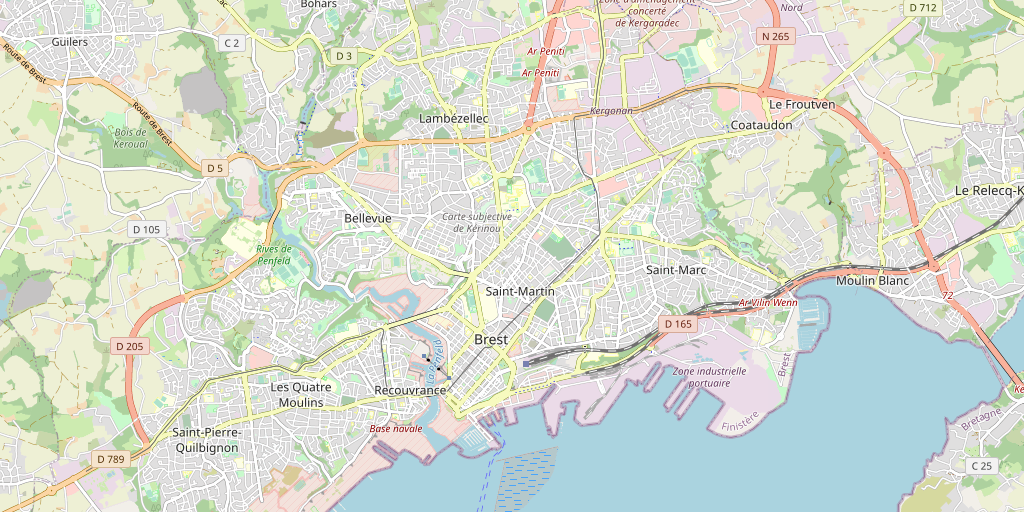

In [16]:
# Obtenir les données

resp = requests.get('https://vigilo.bapav.org/get_issues.php')
df = pd.DataFrame(resp.json())
df = df[df.comment != '']
df.time = pd.to_datetime(df.time, unit='s')
df['julian_day'] = df.time.apply(lambda x: x.timetuple().tm_yday)

# Filtering out data before 2019-01-01
df = df[df.time.apply(lambda x: x.year) > 2019]
df = df.sort_values(by='time', ascending=True)
df = df.reset_index(drop=True)

# Create Box
box = (48.377, -4.556,
       48.416, -4.441)
m = smopy.Map(box, z=20)
m.show_ipython()

In [17]:
class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y      

In [18]:
 class Node():
    def __init__(self, x0, y0, w, h, points):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.points = points
        self.children = []

    def get_width(self):
        return self.width
    
    def get_height(self):
        return self.height
    
    def get_points(self):
        return self.points  

In [19]:
coos = []
for i in range(len(df.coordinates_lon)):
    x = float(df.coordinates_lat.values[i])
    y = float(df.coordinates_lon.values[i])
    coos.append((x, y))

In [20]:
def recursive_subdivide(node, k):
    if len(node.points)<=k:
        return

    w_ = float(node.width/2)
    h_ = float(node.height/2)

    p = contains(node.x0, node.y0, w_, h_, node.points)
    x1 = Node(node.x0, node.y0, w_, h_, p)
    recursive_subdivide(x1, k)

    p = contains(node.x0, node.y0+h_, w_, h_, node.points)
    x2 = Node(node.x0, node.y0+h_, w_, h_, p)
    recursive_subdivide(x2, k)

    p = contains(node.x0+w_, node.y0, w_, h_, node.points)
    x3 = Node(node.x0 + w_, node.y0, w_, h_, p)
    recursive_subdivide(x3, k)

    p = contains(node.x0+w_, node.y0+h_, w_, h_, node.points)
    x4 = Node(node.x0+w_, node.y0+h_, w_, h_, p)
    recursive_subdivide(x4, k)

    node.children = [x1, x2, x3, x4]
   
   
def contains(x, y, w, h, points):
    pts = []
    for point in points:
        if point.x >= x and point.x <= x+w and point.y>=y and point.y<=y+h:
            pts.append(point)
    return pts


def find_children(node):
    if not node.children:
        return [node]
    else:
        children = []
        for child in node.children:
            children += (find_children(child))
    return children

In [21]:
def rectangulize(node):
    rec = np.array([(node.x0,node.y0),
    (node.x0,node.y0+ +node.height),
    (node.x0+node.width,node.y0+node.height),
    (node.x0+node.width,node.y0)], dtype=np.float32)
    return rec

In [22]:
class QTree():
    def __init__(self, k, n,points,cells,m):
        self.threshold = k
        self.points = points
        self.root = Node(48.377, -4.556, 0.039,0.115, self.points)
        self.cells = cells
        self.m = m
        
    def add_point(self, x, y):
        self.points.append(Point(x, y))
    
    def get_points(self):
        return self.points
    
    def get_cells(self):
        return self.cells
    
    def subdivide(self):
        recursive_subdivide(self.root, self.threshold)
        
    
    def graph(self):
        c = find_children(self.root)
        print("Number of segments: %d" %len(c))
        areas = set()
        for el in c:
            areas.add(el.width*el.height)
        print("Minimum segment area: %.3f units" %min(areas))
        for n in c:
            self.cells.append(self.m.to_pixels(rectangulize(n)))
        return

In [23]:
points = []
for i in range(len(df.coordinates_lon)):
    x = float(df.coordinates_lat.values[i])
    y = float(df.coordinates_lon.values[i])
    points.append(Point(x, y))

In [27]:
TE = QTree(10,len(points),points,[],m)

In [28]:
TE.subdivide()
TE.graph()
cells= TE.get_cells()

Number of segments: 94
Minimum segment area: 0.000 units


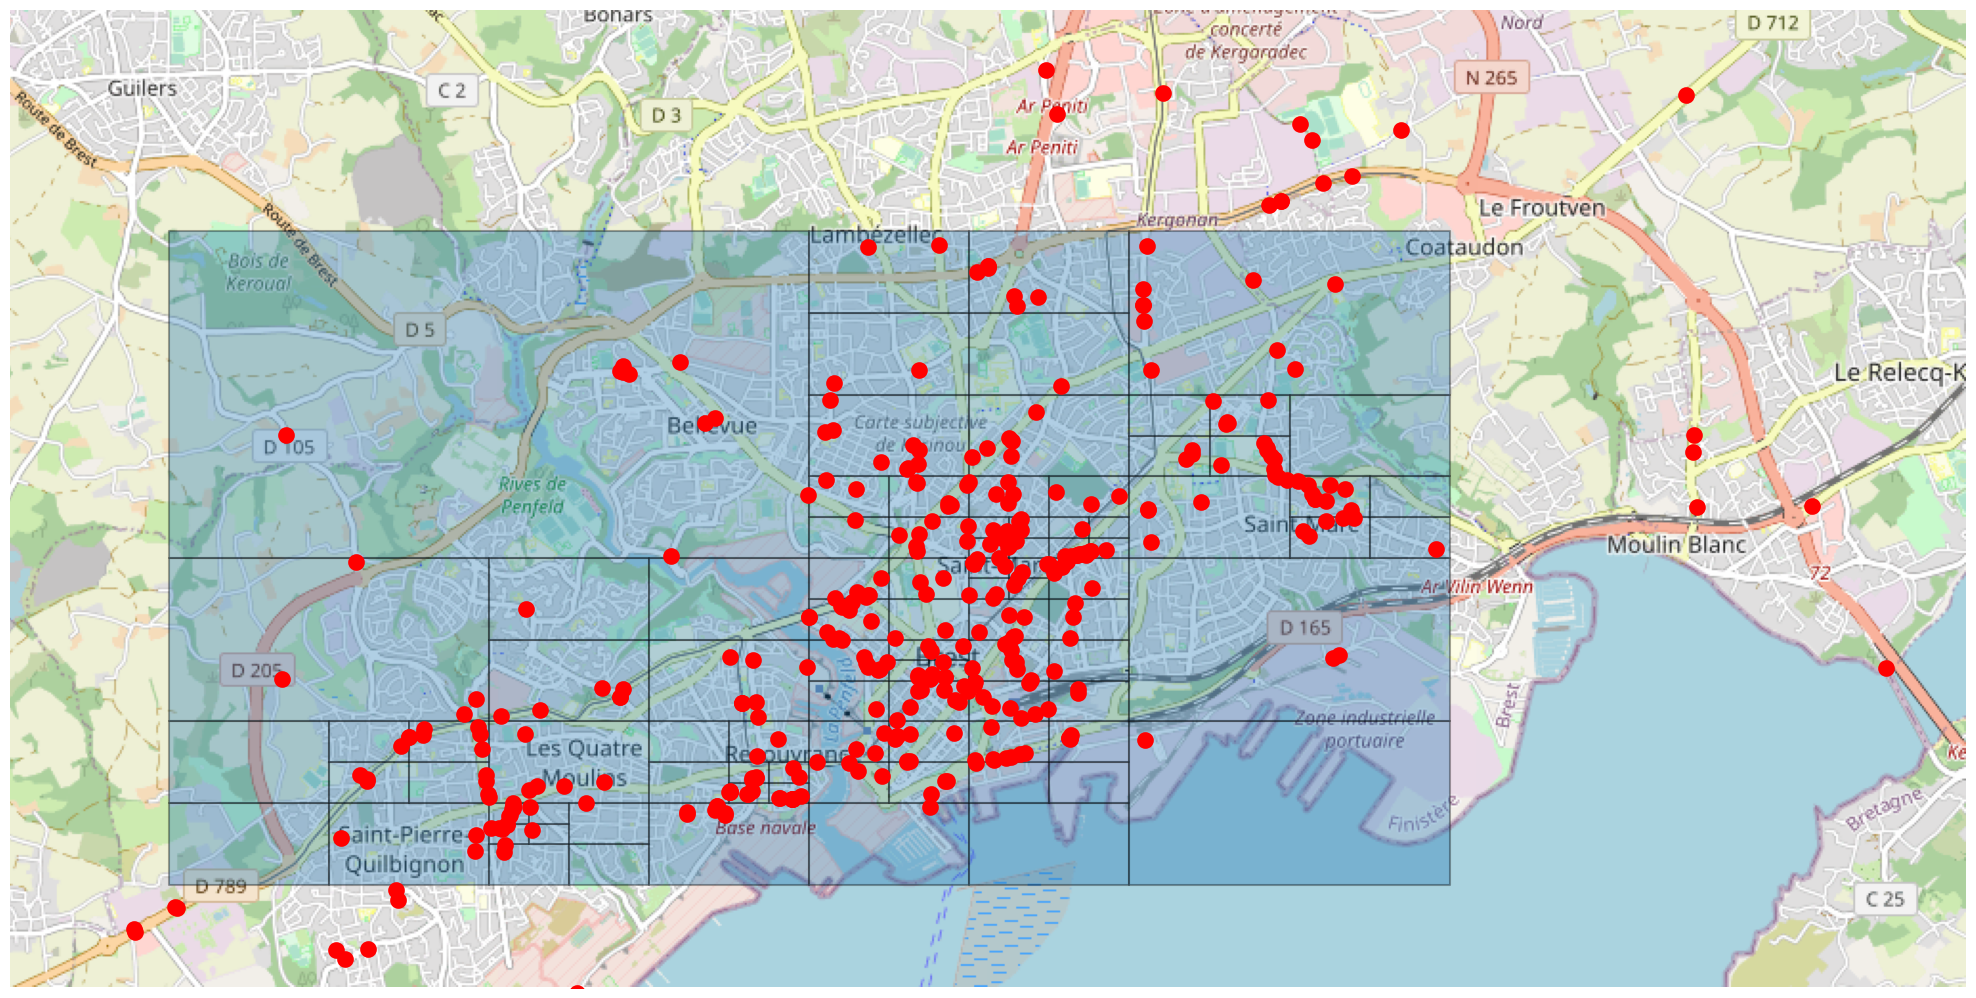

In [29]:
ax = m.show_mpl(figsize=(20, 16))
#x, y = m.to_pixels(48.41392408216084, -4.492457414269447)
#ax.plot(x, y, 'or', ms=10, mew=2);
ax.add_collection(
    mpl.collections.PolyCollection(
        cells,
        edgecolors='k', alpha=.35))
for i in range(len(df.coordinates_lon)):
    x = float(df.coordinates_lat.values[i])
    y = float(df.coordinates_lon.values[i])
    xp, yp = m.to_pixels(x,y)
    ax.plot(xp, yp, 'or', ms=10, mew=2)
